# Mass Shootings in America: A Modern Deconstruction

By Alvin Zhao and Marco Volpi

## Table of Contents

1. Abstract
2. Getting Started
    - 2.1 Required Libraries
    - 2.2 Fetching and Cleaning the Data


## 1. Abstract

Mass shootings have one of the highest media coverage of all incidents. This issue is particarly serious in the United States. One study estimates that nearly one-third of the world's public mass shootings between 1966 and 2012 occured in the United States (Lankford 2016). We live in a society where schools, government facilities, and public institutions actively train and prepare in case of a mass shooting. Clearly, the rise in frequency and media coverage of these horrific events have left a psychological imprint. 

In this analysis, we will be examining six key points: The number of shootings per year, mean fatalities per shooting, race of perpetrator, location of shooting, type of firearm used, and the mental health status of the perpetrator.

The data used has been pulled from three major sources: the Stanford Geospatial Center's Mass Shootings in America database, Everytown's Mass Shooting data, and Mother Jone's Open Source Mass Shooting database.

#results

#brief conclusion

## 2. Getting Started

## 2.1 Required Libraries

The following libraries are required to start this project:

 - pandas
 - matplotlib
 - math
 - numpy
 - seaborn
 - sklearn



In [1]:
!pip install folium
import folium
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn
import sklearn
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from folium.plugins import HeatMap

Below, the function yes_to_bool, maps the "Yes" and "No" responses to True and False, respectively.

In [2]:
def yes_to_bool(data, col_lst):
    for col in col_lst: 
        data[col] = data[col].map({'Yes':True, 'No':False})

In [3]:
et = pd.read_excel('Everytown-mass-shootings-data_2008-2019_19.12.04-1-1.xlsx')
et.rename(columns=et.iloc[6], inplace=True)
et.drop(index=range(0,7), inplace=True)

et.drop(['Females killed', 'Males killed', 'ID',
       'Children and teens killed (0-19)', 'Law enforcement killed',
       'Law enforcement wounded', 'Shooter 1 outcome', 'Shooter 2 age',
       'Shooter 2 gender', 'Shooter 2 prohibited', 'Shooter 2 outcome',
       'Shooter 3 age', 'Shooter 3 gender', 'Shooter 3 prohibited',
       'Shooter 3 outcome', 'Shooter 4 age', 'Shooter 4 gender',
       'Shooter 4 prohibited', 'Shooter 4 outcome',
       'Any shooter prohibited from posessing gun',
       'Any shooter killed intimate partner or family', 'Shooting Location',
       'Narrative','High-capacity magazine', 'Workplace (public)',
       'Place of business (public)', 'Other (public)',
       'Any shooter prior history of DV', 'Gun unknown'], axis=1, inplace=True)

et.rename(columns={
    'Total people shot (killed or injured)':'Total Victims',
    'People killed ':'Fatalities',
    'People wounded':'Injured',
    'Long guns (other rifles & shotguns)':'Long guns',
    'Any shooter displayed dangerous warning signs':'Mental Health Issues',
    'Shooter 1 age':'Age',
    'Shooter 1 gender':'Gender', 
    'Shooter 1 prohibited':'Legal Weapon',
    'School (public)':'School Related'}, inplace=True)

yes_to_bool(et, ['Legal Weapon','School Related','Mental Health Issues'])
et['Legal Weapon'] = ~(et['Legal Weapon'].astype(bool))

In [4]:
mj = pd.read_csv('Mother Jones - Mass Shootings Database, 1982 - 2019 - Sheet1.csv')

tmp = mj["location"].str.split(", ", n = 1, expand = True) 
mj['City'] = tmp[0]
mj['State'] = tmp[1]

mj.drop(['summary',
         'mental_health_details',
         'location',
         'location.1',
         'where_obtained',
         'weapon_details',
         'sources',
         'year',
         'mental_health_sources', 
         'sources_additional_age',
         'type'], axis=1, inplace=True)

mj.rename(columns={
    'case':'Title', 
    'date':'Date',
    'fatalities':'Fatalities', 
    'injured':'Injured', 
    'total_victims':'Total Victims',
    'age_of_shooter':'Age',
    'prior_signs_mental_health_issues':'Mental Health Issues',
    'weapons_obtained_legally':'Legal Weapon',
    'weapon_type':'Weapon Type',
    'race':'Race',
    'gender':'Gender',
    'latitude':'Latitude',
    'longitude':'Longitude',}, inplace=True)

yes_to_bool(mj, ['Mental Health Issues','Legal Weapon'])

In [5]:
st = pd.read_csv('mass-shootings-in-america.csv', sep=';')

st['Long guns'] = st['Number of Rifles'] + st['Number of Shotguns']
st['Assault weapon'] = st['Number of Automatic Guns'] + st['Number of Semi-Automatic Guns']

st.drop(['CaseID',
         'Location',
         'Shooter Name',
         'Number of Victim Fatalities',
         'Day of Week',
         'Description',
         'Date - Detailed',
         'Average Shooter Age',
         'Fate of Shooter at the scene',
         "Shooter's Cause of Death",
         'Place Type',
         'Relationship to Incident Location',
         'Type of Gun - Detailed',
         'Targeted Victim/s - Detailed', 
         'Targeted Victim/s - General',
         'Possible Motive - Detailed',
         'Possible Motive - General',
         'History of Mental Illness - Detailed',
         'Data Source 1',
         'Data Source 2',
         'Data Source 3', 
         'Data Source 4', 
         'Data Source 5', 
         'Data Source 6',
         'Data Source 7', 
         'Number of Shotguns',
         'Number of Rifles',
         'Number of Automatic Guns', 
         'Number of Semi-Automatic Guns',
         'Military Experience', 
         'Class', 
         'geopoint'], axis=1, inplace=True)

st.rename(columns={
    'Total Number of Fatalities':'Fatalities',
    'Number of Victims Injured':'Injured',
    'Total Number of Victims':'Total Victims',
    'Shooter Age(s)':'Age',
    'Shooter Sex':'Gender',
    'Shooter Race':'Race',
    'History of Mental Illness - General':'Mental Health Issues',
    'Type of Gun - General':'Weapon Type',
    'Number of Handguns':'Handgun',
#     'Number of Shotguns':'Shotgun',
#     'Number of Rifles':'Rifle',
#     'Number of Automatic Guns':'Automatic', 
#     'Number of Semi-Automatic Guns':'Semi-Automatic',
    'Total Number of Guns':'Total Guns'}, inplace=True)

yes_to_bool(st, ['School Related','Mental Health Issues'])

In [47]:
ag = pd.concat([st,et,mj], sort=False, ignore_index=True)
ag['DateTime'] = pd.to_datetime(ag['Date'])
ag = ag[ag['DateTime'].dt.year < 2017]
ag['Fatalities'] = ag['Fatalities'].astype('int32')
ag['Injured'] = ag['Injured'].astype('int32')
ag['Total Victims'] = ag['Total Victims'].astype('int32')
ag.drop_duplicates(subset=['DateTime','City','State','Age'], inplace=True)

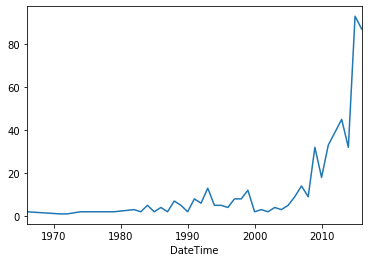

In [48]:
ag.groupby(ag['DateTime'].dt.year).size().plot()

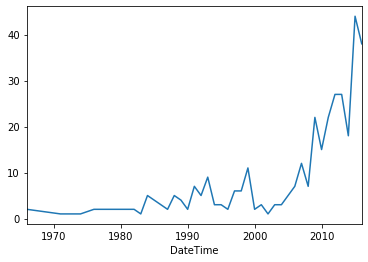

In [49]:
ag[ag['Total Victims'] > 4].groupby(ag['DateTime'].dt.year).size().plot()

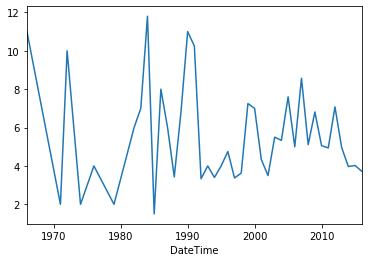

In [50]:
ag.groupby(ag['DateTime'].dt.year)['Fatalities'].mean().plot()

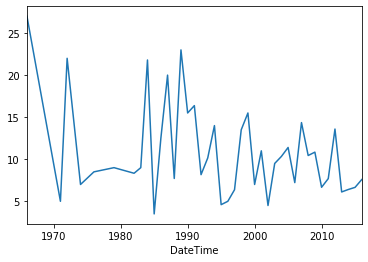

In [51]:
ag.groupby(ag['DateTime'].dt.year)['Total Victims'].mean().plot()

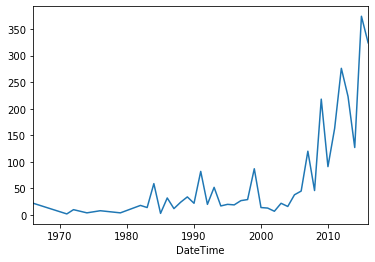

In [52]:
ag.groupby(ag['DateTime'].dt.year)['Fatalities'].sum().plot()

In [53]:
trim_ag = ag[ag['Total Victims'] > 4]
trim_year_count = trim_ag['DateTime'].dt.year.value_counts()

lin_tab = trim_year_count.reset_index().rename(columns={'index': 'year', 'DateTime' : 'count'})
lin_tab['std_count'] = (lin_tab['count'] - lin_tab['count'].min()) / (lin_tab['count'].max() - lin_tab['count'].min())
lin_tab = lin_tab.sort_values(by=['year'])

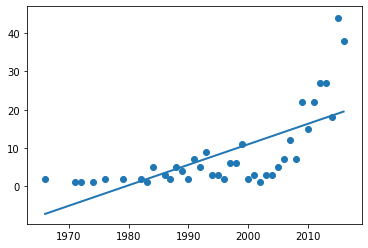

In [54]:
X = np.array([[y] for y in lin_tab['year']])
y = lin_tab['count']
lw=2

reg = linear_model.LinearRegression()
arr = np.array([[y] for y in lin_tab['year']])
fig, ax = plt.subplots()
ax.plot(X, reg.fit(X, y).predict(X), lw=lw)
ax.scatter(X,y)

In [55]:
reg.predict([[2050]])

array([37.6835779])

In [56]:
X = np.array([[y] for y in lin_tab['year']])
y = lin_tab['count']
lw=2

svr = SVR(kernel='rbf', C=100, gamma=0.05, epsilon=.1)

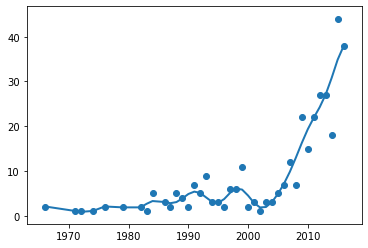

In [57]:
fig, ax = plt.subplots()
ax.plot(X, svr.fit(X, y).predict(X), lw=lw)
ax.scatter(X,y)
# ax.scatter(X[svr.support_], y[svr.support_], s=50,
#                 label='{} support vectors'.format('Polynomial'))
# ax.scatter(X[np.setdiff1d(np.arange(len(X)), svr.support_)],
#             y[np.setdiff1d(np.arange(len(X)), svr.support_)],
#                  facecolor="none", edgecolor="k", s=50)

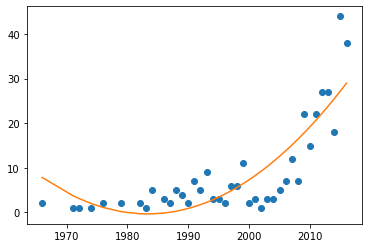

In [58]:
plt.plot(X,y,'o')

poly = PolynomialFeatures(degree=2)
poly_years = poly.fit_transform(X)
reg.fit(poly_years, y)

poly_pred = reg.predict(poly_years)
plt.plot(X,poly_pred)

Number of shootings
Deaths per shooting
Race of Shooter
Location (urban/suburban) (schools)
Type of gun
Mental illness
Sex of shooter

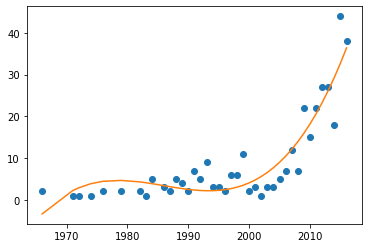

In [59]:
plt.plot(X,y,'o')

poly = PolynomialFeatures(degree=3)
poly_years = poly.fit_transform(X)
reg.fit(poly_years, y)

poly_pred = reg.predict(poly_years)
plt.plot(X,poly_pred)

In [60]:
map_osm = folium.Map(location=[39.29, -90], zoom_start=4)
trim_loc = ag.dropna(subset=['Latitude', 'Longitude']).reset_index(drop=True)
crime_lst = []
for i in range(0,trim_loc.shape[0]):
    crime_lst.append([trim_loc.iloc[i]['Latitude'],trim_loc.iloc[i]['Longitude']])
    
HeatMap(data=crime_lst).add_to(map_osm)
map_osm

In [97]:
map_osm2 = folium.Map(location=[39.29, -90], zoom_start=4)
states = 'https://raw.githubusercontent.com/shawnbot/topogram/master/data/us-states.geojson'

# formatting the series for choropleth data
crime = pd.DataFrame(ag['State'].value_counts().astype(float))
crime = crime.reset_index()
crime.columns = ['State', 'Number']

folium.Choropleth(
    geo_data=states,
    name='choropleth',
    data=crime,
    columns=['State', 'Number'],
    key_on='feature.properties.name',
    fill_color = 'YlOrRd', 
    fill_opacity = 0.7, 
    line_opacity = 0.2,
    legend_name = 'Number of incidents per state'
).add_to(map_osm2)

map_osm2

In [98]:
pop = pd.read_excel('nst-est2018-01.xlsx')
pop.rename(columns=pop.iloc[2], inplace=True)
pop.drop(index=range(0,8), inplace=True)
pop.drop(pop.tail(7).index,inplace=True) 
pop.reset_index(inplace=True, drop=True)
pop.rename(columns={np.nan: 'State'}, inplace=True)
pop['State'] = pop['State'].str[1:]
pop = pop[['State','Census']]
pop.set_index('State', inplace=True)

In [99]:
map_osm3 = folium.Map(location=[39.29, -90], zoom_start=4)
states = 'https://raw.githubusercontent.com/shawnbot/topogram/master/data/us-states.geojson'

# formatting the series for choropleth data
crime = pd.DataFrame(ag['State'].value_counts().astype(float))
# crime.to_json('crime.json')
crime = crime.reset_index()
crime.columns = ['State', 'Number']
crime = crime.join(pop, on='State')
crime['Number'] = (crime['Number'] / crime['Census']) * 1000000

folium.Choropleth(
    geo_data=states,
    name='choropleth',
    data=crime,
    columns=['State', 'Number'],
    key_on='feature.properties.name',
    fill_color = 'YlOrRd', 
    fill_opacity = 0.7, 
    line_opacity = 0.2,
    legend_name = 'Incidents per state normalized by population'
).add_to(map_osm3)

map_osm3

## References

- Lankford, Adam (2016). Public Mass Shooters and Firearms: A Cross-National Study of 171 Countries https://www.ingentaconnect.com/contentone/springer/vav/2016/00000031/00000002/art00001